In [1]:
# BiLSTM-based Intrusion Detection on TON IoT Dataset (Rewritten)

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from collections import Counter
from sklearn.model_selection import StratifiedKFold, train_test_split

# Load Dataset
df = pd.read_csv('../dataset/final_df.csv', low_memory=False)
print("Original DataFrame Head:\n", df.head())
print("\nOriginal Class Distribution:\n", df['type'].value_counts())
print("\nOriginal Label Distribution:\n", df['label'].value_counts())
print("\nOriginal Data Types:\n", df.dtypes)
print("\nOriginal Data Shapes:\n", df.shape)

# --- Data Preprocessing ---
# Clean and impute
df['src_bytes'] = pd.to_numeric(df['src_bytes'], errors='coerce').fillna(0)
df.drop_duplicates(inplace=True)

df.fillna(df.mean(numeric_only=True), inplace=True)
print(f"Shape after dropping duplicates: {df.shape}")

for col in df.columns:
    if df[col].isnull().any():
        if df[col].dtype == 'object':
            df[col].fillna('Missing', inplace=True) # Or df[col].mode()[0]
        else:
            df[col].fillna(df[col].mean(), inplace=True)

print(f"Shape after handling NaNs: {df.shape}")

# Identify targets
TARGET_LABEL = 'label'
TARGET_TYPE = 'type'

# Encode categorical columns
categorical_cols = df.select_dtypes(include='object').columns.tolist()
if TARGET_TYPE in categorical_cols:
    categorical_cols.remove(TARGET_TYPE)

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"Encoded column: {col}")

# Normalize numerical features
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if TARGET_LABEL in numerical_cols:
    numerical_cols.remove(TARGET_LABEL)

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")


2025-09-03 19:49:54.469447: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-03 19:49:54.874113: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-03 19:49:56.267078: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Original DataFrame Head:
            ts         src_ip  src_port        dst_ip  dst_port proto service  \
0  1556499101  192.168.1.193     60396  192.168.1.33      8080   tcp       -   
1  1556494424  192.168.1.193     59273  192.168.1.33      8080   tcp       -   
2  1556487945  192.168.1.193     57717  192.168.1.33      8080   tcp       -   
3  1556508616  192.168.1.193     62682  192.168.1.33        80   tcp       -   
4  1556511697  192.168.1.193     63419  192.168.1.33      8080   tcp       -   

   duration src_bytes  dst_bytes  ... http_response_body_len  \
0  0.000180         0          0  ...                      0   
1  0.000111         0          0  ...                      0   
2  0.000148         0          0  ...                      0   
3  0.000127         0          0  ...                      0   
4  0.000122         0          0  ...                      0   

   http_status_code  http_user_agent  http_orig_mime_types  \
0                 0                -          

In [2]:
# binary_y = df[TARGET_LABEL].values
type_encoder = LabelEncoder()
y_multiclass_encoded = type_encoder.fit_transform(df[TARGET_TYPE])
num_classes = len(le.classes_)
# Convert to one-hot encoding for Keras if using categorical_crossentropy
y_multiclass_onehot = to_categorical(y_multiclass_encoded)

y_multiclass_labels = np.argmax(y_multiclass_onehot, axis=1)

# Drop targets from features
X = df.drop(columns=[TARGET_LABEL, TARGET_TYPE]).values
print("Feature shape (flat):", X.shape)
# print("Binary target shape:", binary_y.shape)
print("Multi-class target shape:", y_multiclass_labels.shape)

# print the class distribution of binary_y and y_multiclass_labels
# print("Binary target class distribution:")
# print(Counter(binary_y))
print("Multi-class target class distribution:")
print(Counter(y_multiclass_labels))

Feature shape (flat): (441043, 44)
Multi-class target shape: (441043,)
Multi-class target class distribution:
Counter({np.int64(5): 300000, np.int64(0): 20000, np.int64(1): 20000, np.int64(2): 20000, np.int64(3): 20000, np.int64(6): 20000, np.int64(7): 20000, np.int64(8): 20000, np.int64(4): 1043})


In [3]:
# 1. Split BEFORE SMOTE (to avoid leakage)
# ----------------------------------------
X_train, X_test, y_train_multi, y_test_multi = train_test_split(
    X,
    y_multiclass_onehot,
    test_size=0.2,
    random_state=42,
    stratify=y_multiclass_encoded  # stratify on binary for this example
)

# Reset indices
X_train = pd.DataFrame(X_train).reset_index(drop=True).values
X_test = pd.DataFrame(X_test).reset_index(drop=True).values

print(f"\nX_train shape: {X_train.shape}")
print(f"y_train_multiclass labels shape: {y_train_multi.shape}")
print(f"X_test  shape: {X_test.shape}")
print(f"y_test_multiclass labels shape: {y_test_multi.shape}")

# print the class distribution of binary_y and y_multiclass
# print the class distribution of binary_y and y_multiclass
print("Multi-class target class distribution (train):")
print(Counter(np.argmax(y_train_multi, axis=1)))
print("Multi-class target class distribution (test):")
print(Counter(np.argmax(y_test_multi, axis=1)))

# scaling the training data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Scaling complete.")


X_train shape: (352834, 44)
y_train_multiclass labels shape: (352834, 9)
X_test  shape: (88209, 44)
y_test_multiclass labels shape: (88209, 9)
Multi-class target class distribution (train):
Counter({np.int64(5): 240000, np.int64(0): 16000, np.int64(6): 16000, np.int64(7): 16000, np.int64(8): 16000, np.int64(2): 16000, np.int64(1): 16000, np.int64(3): 16000, np.int64(4): 834})
Multi-class target class distribution (test):
Counter({np.int64(5): 60000, np.int64(1): 4000, np.int64(3): 4000, np.int64(6): 4000, np.int64(0): 4000, np.int64(8): 4000, np.int64(7): 4000, np.int64(2): 4000, np.int64(4): 209})
Scaling complete.


In [4]:
# --- Create Sequences ---
def create_sequences(
    X,
    y,
    window_size: int = 10,
    debug: bool = False,
    trace_limit: int = 5
):
    # Convert to numpy if not already
    X = np.asarray(X)
    y = np.asarray(y)

    # Input validation
    if len(X) != len(y):
        raise ValueError("X and y must have the same number of samples")
    if len(X.shape) != 2:
        raise ValueError("X must be a 2D array: (samples, features)")
    if len(y.shape) > 2:
        raise ValueError("y must be a 1D or 2D array")

    X_seq, y_seq = [], []
    total = len(X) - window_size + 1
    if debug:
        print(f"Total samples: {len(X)} | Generating {total} sequences (window_size={window_size})")

    for i in range(total):
        window = X[i : i + window_size]
        label = y[i + window_size - 1]
        X_seq.append(window)
        y_seq.append(label)

        if debug and i < trace_limit:
            print(f"\n--- Seq {i+1}/{total} ---")
            print(f"  X indices: {i} to {i+window_size-1}")
            print(f"  y index:   {i+window_size-1} → label={label}")
            print(f"  window.shape: {window.shape}")

    if debug:
        print(f"\nTotal sequences generated: {len(X_seq)}")

    return np.array(X_seq), np.array(y_seq)


TIMESTEPS = 20
X_train_seq, y_train_seq = create_sequences(X_train, y_train_multi, window_size=TIMESTEPS, debug=True)
X_test_seq, y_test_seq = create_sequences(X_test, y_test_multi, window_size=TIMESTEPS, debug=True)


print("Train sequence shape:", X_train_seq.shape)  # (samples, timesteps, features)
print("Test sequence shape:", X_test_seq.shape)
print("multi target distribution:", Counter(np.argmax(y_train_multi, axis=1)))

# counters
print("Class distribution in y_train_seq:", Counter(np.argmax(y_train_seq, axis=1)))
print("Class distribution in y_test_seq:", Counter(np.argmax(y_test_seq, axis=1)))

# multiclass sequence generation.
# X_train_seq_multi, y_train_seq_multi = create_sequences(X_train, y_train_multi, debug=True)
# X_test_seq_multi, y_test_seq_multi = create_sequences(X_test, y_test_multi, debug=True)


Total samples: 352834 | Generating 352815 sequences (window_size=20)

--- Seq 1/352815 ---
  X indices: 0 to 19
  y index:   19 → label=[0. 0. 1. 0. 0. 0. 0. 0. 0.]
  window.shape: (20, 44)

--- Seq 2/352815 ---
  X indices: 1 to 20
  y index:   20 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.shape: (20, 44)

--- Seq 3/352815 ---
  X indices: 2 to 21
  y index:   21 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.shape: (20, 44)

--- Seq 4/352815 ---
  X indices: 3 to 22
  y index:   22 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.shape: (20, 44)

--- Seq 5/352815 ---
  X indices: 4 to 23
  y index:   23 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.shape: (20, 44)

Total sequences generated: 352815
Total samples: 88209 | Generating 88190 sequences (window_size=20)

--- Seq 1/88190 ---
  X indices: 0 to 19
  y index:   19 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.shape: (20, 44)

--- Seq 2/88190 ---
  X indices: 1 to 20
  y index:   20 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.

In [5]:
from sklearn.utils import shuffle

# X_train_seq_bal_shuffle, y_train_seq_bal_shuffle = shuffle(X_train_seq_bal, y_train_seq_bal, random_state=42)
X_train_seq_bal_shuffle, y_train_seq_bal_shuffle = shuffle(X_train_seq, y_train_seq, random_state=42)

val_fraction = 0.2
n_total = X_train_seq_bal_shuffle.shape[0]
n_val = int(n_total * val_fraction)

X_val_seq = X_train_seq_bal_shuffle[-n_val:]
y_val_seq = y_train_seq_bal_shuffle[-n_val:]
X_train_seq_final = X_train_seq_bal_shuffle[:-n_val]
y_train_seq_final = y_train_seq_bal_shuffle[:-n_val]

print("Final training shapes:")
print(f"X_train_seq_final shape: {X_train_seq_final.shape}")
print(f"y_train_seq_final shape: {y_train_seq_final.shape}")
print(f"X_val_seq shape: {X_val_seq.shape}")
print(f"y_val_seq shape: {y_val_seq.shape}")

print("Final training label distributions:")
print(f"y_train_seq_final distribution: {Counter(np.argmax(y_train_seq_final, axis=1))}")
print(f"y_val_seq distribution: {Counter(np.argmax(y_val_seq, axis=1))}")

Final training shapes:
X_train_seq_final shape: (282252, 20, 44)
y_train_seq_final shape: (282252, 9)
X_val_seq shape: (70563, 20, 44)
y_val_seq shape: (70563, 9)
Final training label distributions:
y_train_seq_final distribution: Counter({np.int64(5): 192120, np.int64(7): 12859, np.int64(2): 12851, np.int64(3): 12828, np.int64(6): 12792, np.int64(8): 12747, np.int64(0): 12710, np.int64(1): 12690, np.int64(4): 655})
y_val_seq distribution: Counter({np.int64(5): 47868, np.int64(1): 3310, np.int64(0): 3289, np.int64(8): 3252, np.int64(6): 3207, np.int64(3): 3172, np.int64(2): 3149, np.int64(7): 3138, np.int64(4): 178})


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import Precision
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, AUC
from sklearn.metrics import (confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, roc_auc_score, classification_report, roc_curve, precision_recall_curve)
import matplotlib.pyplot as plt

# Model definition
model = Sequential([
    Bidirectional(LSTM(
        128, 
        return_sequences=True,  # Only final output
        recurrent_dropout=0.2,
        recurrent_activation='sigmoid',
        activation='tanh'
    ),
    input_shape=(X_train_seq_final.shape[1], X_train_seq_final.shape[2])),
    LayerNormalization(),
    Dropout(0.2),
    Bidirectional(LSTM(64)),
    LayerNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(9, activation='softmax')
])
model.summary()

optimizer = Adam(
    learning_rate=0.0001,  # Very low initial LR
    clipnorm=1.0,  # Gradient clipping to prevent exploding gradients
    weight_decay=1e-4
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        AUC(name='auc'),
        Recall(name='recall'),
        Precision(name='precision')
    ]
)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(y_multiclass_onehot.shape[1]),
    y=y_multiclass_onehot.argmax(axis=1)
)
class_weight_dict = dict(enumerate(class_weights))
# 🚀 Boost class 4 priority (e.g., 2x higher than balanced weight)
class_weight_dict[4] *= 2.0

# Train
history = model.fit(
    X_train_seq_final, y_train_seq_final,
    validation_data=(X_val_seq, y_val_seq),
    epochs=10,
    batch_size=64,
    shuffle=False,  # Important for time series
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1
)

results = model.evaluate(X_test_seq, y_test_seq, verbose=2)

print("Test Loss: {}".format(results[0]))
print("Test Accuracy: {}".format(results[1]))


I0000 00:00:1756908304.710665    3750 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2278 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2050, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 20, 256)        │       177,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 20, 256)        │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 128)            │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 351,113 (1.34 MB)

 Trainable params: 351,113 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


2025-09-03 19:50:13.105469: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200


4411/4411 ━━━━━━━━━━━━━━━━━━━━ 168s 37ms/step - accuracy: 0.5848 - auc: 0.9139 - loss: 1.5430 - precision: 0.7620 - recall: 0.4621 - val_accuracy: 0.7841 - val_auc: 0.9638 - val_loss: 0.7225 - val_precision: 0.8398 - val_recall: 0.7154 - learning_rate: 1.0000e-04
Epoch 2/10
4411/4411 ━━━━━━━━━━━━━━━━━━━━ 162s 37ms/step - accuracy: 0.8118 - auc: 0.9760 - loss: 0.8073 - precision: 0.8540 - recall: 0.7744 - val_accuracy: 0.8830 - val_auc: 0.9855 - val_loss: 0.4234 - val_precision: 0.8968 - val_recall: 0.8685 - learning_rate: 1.0000e-04
Epoch 3/10
4411/4411 ━━━━━━━━━━━━━━━━━━━━ 166s 38ms/step - accuracy: 0.8743 - auc: 0.9877 - loss: 0.5017 - precision: 0.8928 - recall: 0.8589 - val_accuracy: 0.9129 - val_auc: 0.9894 - val_loss: 0.3214 - val_precision: 0.9219 - val_recall: 0.9044 - learning_rate: 1.0000e-04
Epoch 4/10
4411/4411 ━━━━━━━━━━━━━━━━━━━━ 166s 38ms/step - accuracy: 0.9013 - auc: 0.9907 - loss: 0.3634 - precision: 0.9129 - recall: 0.8907 - val_accuracy: 0.9231 - val_auc: 0.9912 - v

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3997
           1       0.91      0.97      0.94      3998
           2       0.92      0.97      0.94      4000
           3       0.91      0.98      0.95      3999
           4       0.23      0.95      0.37       209
           5       1.00      0.96      0.98     59991
           6       0.89      1.00      0.94      3998
           7       0.95      0.99      0.97      3999
           8       0.91      0.92      0.91      3999

    accuracy                           0.96     88190
   macro avg       0.85      0.97      0.89     88190
weighted avg       0.97      0.96      0.97     88190

[[ 3997     0     0     0     0     0     0     0     0]
 [    0  3866     0    97     2    14     7     9     3]
 [    0     0  3866    15     0   119     0     0     0]
 [    0    16    36  3937     0     7     1     2     0]
 [    0     0     0    

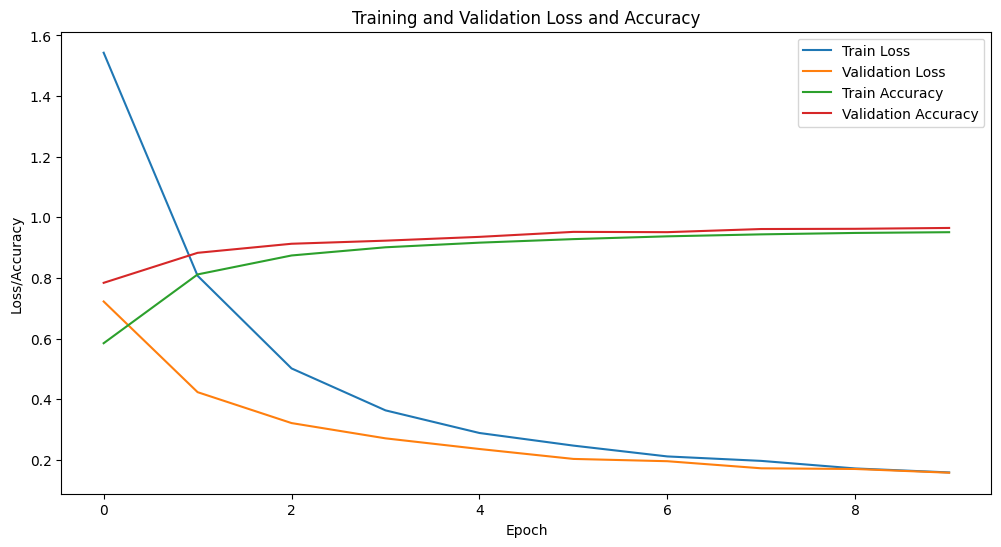

In [7]:

# Print classification report
y_pred_probs = model.predict(X_test_seq)
y_pred_classes = y_pred_probs.argmax(axis=1)
y_true_classes = y_test_seq.argmax(axis=1)
print(classification_report(y_true_classes, y_pred_classes))

#confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(cm)

# For multi-class, FNR and FPR are not simply tn, fp, fn, tp.
# If you want per-class FNR/FPR:
fnr = []
fpr = []
for i in range(cm.shape[0]):
    fn = cm[i, :].sum() - cm[i, i]
    tp = cm[i, i]
    fp = cm[:, i].sum() - cm[i, i]
    tn = cm.sum() - (tp + fn + fp)
    fnr.append(fn / (fn + tp) if (fn + tp) > 0 else 0)
    fpr.append(fp / (fp + tn) if (fp + tn) > 0 else 0)
print("False Negative Rate (FNR) per class:", fnr)
print("False Positive Rate (FPR) per class:", fpr)

# plot validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()


In [8]:
# Hyperparameter Tuning with Bayesian Optimization (BayesSearchCV)
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold

def build_bilstm_model(
    lstm_units=64,
    hidden_layer=32,
    dropout=0.2,
    learning_rate=0.001,
    input_shape=(30, 44)
):
    model = Sequential([
        Bidirectional(LSTM(int(lstm_units*2), return_sequences=True, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0.2), input_shape=input_shape),
        LayerNormalization(),
        Dropout(dropout),
        Bidirectional(LSTM(int(lstm_units))),
        LayerNormalization(),
        Dropout(dropout),
        Dense(int(hidden_layer), activation='relu'),
        Dense(9, activation='softmax')
    ])
    optimizer = Adam(learning_rate=learning_rate, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

from sklearn.metrics import make_scorer

def constrained_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        acc = accuracy_score(y_true, y_pred)
        # Constraints: FNR ≤ 0.01, FPR ≤ 0.5, Accuracy > 0.90
        if fnr <= 0.01 and fpr <= 0.5 and acc > 0.90:
            print(f"Valid model found: FNR={fnr}, FPR={fpr}, Acc={acc}")
            return acc
        else:
            print(f"Model rejected: FNR={fnr}, FPR={fpr}, Acc={acc}")
            return 0
    else:
        # If confusion matrix is not 2x2, return 0
        return 0

constrained_scorer = make_scorer(constrained_score)
cv_strategy = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(y_multiclass_onehot.shape[1]),
    y=y_multiclass_onehot.argmax(axis=1)
)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict[4] *= 5.0

# Wrap the model for scikit-learn compatibility
keras_clf = KerasClassifier(
    model=build_bilstm_model,
    input_shape=(X_train_seq_final.shape[1], X_train_seq_final.shape[2])
)

# Define the hyperparameter search space
param_space = {
    'model__lstm_units': Integer(64, 128),
    'model__hidden_layer': Integer(16, 32),
    'model__dropout': Real(0.2, 0.4),
    'model__learning_rate': Real(1e-4, 1e-2, prior='log-uniform'),
    'batch_size': Categorical([64, 128]),
    'epochs': Integer(5, 10)
}

opt = BayesSearchCV(
    estimator=keras_clf,
    search_spaces=param_space,
    n_iter=10,
    # scoring=constrained_scorer,
    scoring="accuracy",
    # cv=2,
    cv=cv_strategy,
    n_jobs=1,
    verbose=2,
    refit=True
)

# Convert one-hot encoded targets to integer labels
y_train_seq_final_labels = np.argmax(y_train_seq_final, axis=1)
y_test_seq_labels = np.argmax(y_test_seq, axis=1)

# Fit the optimizer (this may take a while)
opt.fit(X_train_seq_final, y_train_seq_final_labels, callbacks=[early_stopping, reduce_lr], validation_split=0.2, class_weight=class_weight_dict)

print('Best parameters:', opt.best_params_)
print('Best cross-validation accuracy:', opt.best_score_)

# Evaluate on test set
test_score = opt.score(X_test_seq, y_test_seq_labels)
print('Test set accuracy:', test_score)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 76s 41ms/step - accuracy: 0.4055 - loss: 3.2449 - val_accuracy: 0.6667 - val_loss: 0.8954
Epoch 2/6
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 71s 40ms/step - accuracy: 0.7000 - loss: 2.3052 - val_accuracy: 0.7910 - val_loss: 0.7083
Epoch 3/6
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 71s 40ms/step - accuracy: 0.7771 - loss: 1.8398 - val_accuracy: 0.8570 - val_loss: 0.5261
Epoch 4/6
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 71s 40ms/step - accuracy: 0.8255 - loss: 1.2783 - val_accuracy: 0.8786 - val_loss: 0.4408
Epoch 5/6
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 70s 40ms/step - accuracy: 0.8539 - loss: 0.9768 - val_accuracy: 0.8977 - val_loss: 0.3601
Epoch 6/6
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 70s 40ms/step - accuracy: 0.8742 - loss: 0.6932 - val_accuracy: 0.9125 - val_loss: 0.3305
2206/2206 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step
[CV] END batch_size=64, epochs=6, model__dropout=0.35720287593601613, model__hidden_layer=21, model__learning_rate=0.00016553202292661593, model__lstm_units=95; total ti

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 74s 40ms/step - accuracy: 0.4444 - loss: 2.8000 - val_accuracy: 0.7283 - val_loss: 0.8655
Epoch 2/6
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 70s 39ms/step - accuracy: 0.6960 - loss: 2.1409 - val_accuracy: 0.7816 - val_loss: 0.7241
Epoch 3/6
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 69s 39ms/step - accuracy: 0.7542 - loss: 1.9087 - val_accuracy: 0.8378 - val_loss: 0.5609
Epoch 4/6
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 69s 39ms/step - accuracy: 0.8040 - loss: 1.5616 - val_accuracy: 0.8795 - val_loss: 0.4563
Epoch 5/6
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 69s 39ms/step - accuracy: 0.8412 - loss: 1.1874 - val_accuracy: 0.8968 - val_loss: 0.4001
Epoch 6/6
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 69s 39ms/step - accuracy: 0.8601 - loss: 0.9055 - val_accuracy: 0.8879 - val_loss: 0.3729
2206/2206 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step
[CV] END batch_size=64, epochs=6, model__dropout=0.35720287593601613, model__hidden_layer=21, model__learning_rate=0.00016553202292661593, model__lstm_units=95; total ti

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/7
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 79s 43ms/step - accuracy: 0.0056 - loss: 3.0682 - val_accuracy: 0.0027 - val_loss: 2.2204
Epoch 2/7
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 75s 42ms/step - accuracy: 0.0028 - loss: 3.0244 - val_accuracy: 0.0027 - val_loss: 2.2301
Epoch 3/7
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 75s 42ms/step - accuracy: 0.0022 - loss: 2.9918 - val_accuracy: 0.0027 - val_loss: 2.2390
Epoch 4/7
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 75s 42ms/step - accuracy: 0.0023 - loss: 2.9684 - val_accuracy: 0.0027 - val_loss: 2.2435
Epoch 5/7
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 75s 42ms/step - accuracy: 0.0022 - loss: 2.9615 - val_accuracy: 0.0027 - val_loss: 2.2485
Epoch 6/7
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 74s 42ms/step - accuracy: 0.0023 - loss: 2.9538 - val_accuracy: 0.0027 - val_loss: 2.2526
Epoch 7/7
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 74s 42ms/step - accuracy: 0.0022 - loss: 2.9578 - val_accuracy: 0.0027 - val_loss: 2.2601
2206/2206 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step
[CV] END batch_size=64, epochs=7, mode

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/7
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 78s 42ms/step - accuracy: 0.0055 - loss: 3.0488 - val_accuracy: 0.0028 - val_loss: 2.2159
Epoch 2/7
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 75s 43ms/step - accuracy: 0.0022 - loss: 3.0030 - val_accuracy: 0.0028 - val_loss: 2.2188
Epoch 3/7
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 74s 42ms/step - accuracy: 0.0022 - loss: 2.9865 - val_accuracy: 0.0028 - val_loss: 2.2343
Epoch 4/7
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 74s 42ms/step - accuracy: 0.0022 - loss: 2.9639 - val_accuracy: 0.0028 - val_loss: 2.2429
Epoch 5/7
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 74s 42ms/step - accuracy: 0.0023 - loss: 2.9601 - val_accuracy: 0.0028 - val_loss: 2.2514
Epoch 6/7
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 74s 42ms/step - accuracy: 0.0032 - loss: 2.9499 - val_accuracy: 0.0028 - val_loss: 2.2500
Epoch 7/7
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 74s 42ms/step - accuracy: 0.0022 - loss: 2.9425 - val_accuracy: 0.0028 - val_loss: 2.2498
2206/2206 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step
[CV] END batch_size=64, epochs=7, mode

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
883/883 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.0085 - loss: 2.8636 - val_accuracy: 0.0027 - val_loss: 2.4246
Epoch 2/10
883/883 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.0022 - loss: 2.7843 - val_accuracy: 0.0027 - val_loss: 2.5254
Epoch 3/10
883/883 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.0022 - loss: 2.7801 - val_accuracy: 0.0027 - val_loss: 2.4693
Epoch 4/10
883/883 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.0022 - loss: 2.7801 - val_accuracy: 0.0027 - val_loss: 2.4545
Epoch 5/10
883/883 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.0022 - loss: 2.7820 - val_accuracy: 0.0027 - val_loss: 2.4923
Epoch 6/10
883/883 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.0022 - loss: 2.7793 - val_accuracy: 0.0027 - val_loss: 2.3985
Epoch 7/10
883/883 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.0022 - loss: 2.7821 - val_accuracy: 0.0027 - val_loss: 2.4701
Epoch 8/10
883/883 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.0022 - loss: 2.7785 - 

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
883/883 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.0415 - loss: 3.1906 - val_accuracy: 0.0456 - val_loss: 2.1542
Epoch 2/10
883/883 ━━━━━━━━━━━━━━━━━━━━ 35s 40ms/step - accuracy: 0.0818 - loss: 3.6564 - val_accuracy: 0.0456 - val_loss: 2.1819
Epoch 3/10
883/883 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.0828 - loss: 4.0962 - val_accuracy: 0.0468 - val_loss: 2.0441
Epoch 4/10
883/883 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.1146 - loss: 4.5268 - val_accuracy: 0.0445 - val_loss: 2.0651
Epoch 5/10
883/883 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.1160 - loss: 4.7906 - val_accuracy: 0.0445 - val_loss: 2.1779
Epoch 6/10
883/883 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.1035 - loss: 4.9723 - val_accuracy: 0.0456 - val_loss: 2.1974
Epoch 7/10
883/883 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.1102 - loss: 5.2720 - val_accuracy: 0.0470 - val_loss: 2.0000
Epoch 8/10
883/883 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.1075 - loss: 5.4460 - 

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/7
883/883 ━━━━━━━━━━━━━━━━━━━━ 38s 39ms/step - accuracy: 0.0055 - loss: 2.9585 - val_accuracy: 0.0027 - val_loss: 2.3501
Epoch 2/7
883/883 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - accuracy: 0.0176 - loss: 2.9501 - val_accuracy: 0.0470 - val_loss: 2.1272
Epoch 3/7
883/883 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - accuracy: 0.0796 - loss: 3.2879 - val_accuracy: 0.0027 - val_loss: 2.3220
Epoch 4/7
883/883 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - accuracy: 0.2000 - loss: 2.4757 - val_accuracy: 0.5994 - val_loss: 1.0985
Epoch 5/7
883/883 ━━━━━━━━━━━━━━━━━━━━ 34s 39ms/step - accuracy: 0.6124 - loss: 1.7741 - val_accuracy: 0.7244 - val_loss: 0.8101
Epoch 6/7
883/883 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - accuracy: 0.7446 - loss: 1.3882 - val_accuracy: 0.8284 - val_loss: 0.6083
Epoch 7/7
883/883 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - accuracy: 0.7808 - loss: 1.1646 - val_accuracy: 0.8811 - val_loss: 0.4767
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step
[CV] END batch_size=128, epochs=7, model__dropout=0.

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/7
883/883 ━━━━━━━━━━━━━━━━━━━━ 39s 39ms/step - accuracy: 0.0196 - loss: 2.9625 - val_accuracy: 0.0028 - val_loss: 2.3144
Epoch 2/7
883/883 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - accuracy: 0.0435 - loss: 3.0855 - val_accuracy: 0.0028 - val_loss: 2.1325
Epoch 3/7
883/883 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - accuracy: 0.0889 - loss: 2.8850 - val_accuracy: 0.2600 - val_loss: 1.5666
Epoch 4/7
883/883 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - accuracy: 0.5738 - loss: 1.7657 - val_accuracy: 0.7468 - val_loss: 0.7683
Epoch 5/7
883/883 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - accuracy: 0.7164 - loss: 1.4375 - val_accuracy: 0.8160 - val_loss: 0.6299
Epoch 6/7
883/883 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - accuracy: 0.7964 - loss: 1.0143 - val_accuracy: 0.8597 - val_loss: 0.4178
Epoch 7/7
883/883 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - accuracy: 0.8394 - loss: 0.8442 - val_accuracy: 0.8777 - val_loss: 0.3880
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step
[CV] END batch_size=128, epochs=7, model__dropout=0.

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 46s 48ms/step - accuracy: 0.2829 - loss: 3.0974 - val_accuracy: 0.6012 - val_loss: 1.1488
Epoch 2/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - accuracy: 0.6081 - loss: 2.1720 - val_accuracy: 0.6841 - val_loss: 0.9304
Epoch 3/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - accuracy: 0.6766 - loss: 1.8267 - val_accuracy: 0.7118 - val_loss: 0.8245
Epoch 4/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - accuracy: 0.7304 - loss: 1.5486 - val_accuracy: 0.8033 - val_loss: 0.7082
Epoch 5/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - accuracy: 0.7790 - loss: 1.2202 - val_accuracy: 0.8437 - val_loss: 0.5777
Epoch 6/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - accuracy: 0.8155 - loss: 0.9769 - val_accuracy: 0.8602 - val_loss: 0.5173
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step
[CV] END batch_size=128, epochs=6, model__dropout=0.38150892628478994, model__hidden_layer=29, model__learning_rate=0.0001639226525747661, model__lstm_units=116; total time= 4.5min


/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 46s 48ms/step - accuracy: 0.3204 - loss: 2.8036 - val_accuracy: 0.5628 - val_loss: 1.2240
Epoch 2/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - accuracy: 0.6273 - loss: 1.9846 - val_accuracy: 0.7221 - val_loss: 0.9037
Epoch 3/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - accuracy: 0.7020 - loss: 1.7414 - val_accuracy: 0.7584 - val_loss: 0.7445
Epoch 4/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - accuracy: 0.7468 - loss: 1.5604 - val_accuracy: 0.8271 - val_loss: 0.6338
Epoch 5/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - accuracy: 0.7850 - loss: 1.3025 - val_accuracy: 0.8578 - val_loss: 0.5230
Epoch 6/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - accuracy: 0.8143 - loss: 1.1219 - val_accuracy: 0.8742 - val_loss: 0.4484
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step
[CV] END batch_size=128, epochs=6, model__dropout=0.38150892628478994, model__hidden_layer=29, model__learning_rate=0.0001639226525747661, model__lstm_units=116; total time= 4.5min


/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
883/883 ━━━━━━━━━━━━━━━━━━━━ 39s 39ms/step - accuracy: 0.2490 - loss: 2.9432 - val_accuracy: 0.5179 - val_loss: 1.2126
Epoch 2/5
883/883 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - accuracy: 0.6019 - loss: 2.1755 - val_accuracy: 0.7079 - val_loss: 0.8982
Epoch 3/5
883/883 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - accuracy: 0.6856 - loss: 1.7392 - val_accuracy: 0.7532 - val_loss: 0.7634
Epoch 4/5
883/883 ━━━━━━━━━━━━━━━━━━━━ 35s 40ms/step - accuracy: 0.7420 - loss: 1.4917 - val_accuracy: 0.8213 - val_loss: 0.6197
Epoch 5/5
883/883 ━━━━━━━━━━━━━━━━━━━━ 34s 39ms/step - accuracy: 0.7838 - loss: 1.1643 - val_accuracy: 0.8504 - val_loss: 0.5069
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step
[CV] END batch_size=128, epochs=5, model__dropout=0.29817213067030646, model__hidden_layer=30, model__learning_rate=0.00017284312738353647, model__lstm_units=67; total time= 3.2min


/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
883/883 ━━━━━━━━━━━━━━━━━━━━ 38s 39ms/step - accuracy: 0.3590 - loss: 2.8139 - val_accuracy: 0.5841 - val_loss: 1.2054
Epoch 2/5
883/883 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - accuracy: 0.6192 - loss: 1.9245 - val_accuracy: 0.7057 - val_loss: 0.8823
Epoch 3/5
883/883 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - accuracy: 0.6894 - loss: 1.6800 - val_accuracy: 0.7428 - val_loss: 0.7647
Epoch 4/5
883/883 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - accuracy: 0.7362 - loss: 1.4528 - val_accuracy: 0.8060 - val_loss: 0.6312
Epoch 5/5
883/883 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - accuracy: 0.7750 - loss: 1.2054 - val_accuracy: 0.8595 - val_loss: 0.5147
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step
[CV] END batch_size=128, epochs=5, model__dropout=0.29817213067030646, model__hidden_layer=30, model__learning_rate=0.00017284312738353647, model__lstm_units=67; total time= 3.1min
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 45s 46ms/step - accuracy: 0.2519 - loss: 3.0187 - val_accuracy: 0.6199 - val_loss: 1.1288
Epoch 2/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.6415 - loss: 1.9855 - val_accuracy: 0.7332 - val_loss: 0.8611
Epoch 3/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.7153 - loss: 1.5876 - val_accuracy: 0.7461 - val_loss: 0.8442
Epoch 4/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.7628 - loss: 1.2896 - val_accuracy: 0.8394 - val_loss: 0.5887
Epoch 5/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.8094 - loss: 1.0515 - val_accuracy: 0.8603 - val_loss: 0.5565
Epoch 6/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.8384 - loss: 0.8625 - val_accuracy: 0.8946 - val_loss: 0.4411
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step
[CV] END batch_size=128, epochs=6, model__dropout=0.2734005066464352, model__hidden_layer=19, model__learning_rate=0.000178763115965137, model__lstm_units=97; total time= 4.4min


/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 45s 46ms/step - accuracy: 0.1462 - loss: 2.9258 - val_accuracy: 0.3447 - val_loss: 1.6025
Epoch 2/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.6062 - loss: 2.0028 - val_accuracy: 0.6677 - val_loss: 0.9996
Epoch 3/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.6901 - loss: 1.7051 - val_accuracy: 0.7632 - val_loss: 0.7601
Epoch 4/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.7456 - loss: 1.4707 - val_accuracy: 0.8104 - val_loss: 0.6860
Epoch 5/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.7892 - loss: 1.2344 - val_accuracy: 0.8589 - val_loss: 0.5513
Epoch 6/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.8305 - loss: 0.9294 - val_accuracy: 0.8885 - val_loss: 0.4637
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step
[CV] END batch_size=128, epochs=6, model__dropout=0.2734005066464352, model__hidden_layer=19, model__learning_rate=0.000178763115965137, model__lstm_units=97; total time= 4.4min
Fit

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 81s 44ms/step - accuracy: 0.5699 - loss: 2.9272 - val_accuracy: 0.7685 - val_loss: 0.6929
Epoch 2/9
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 76s 43ms/step - accuracy: 0.7841 - loss: 1.6921 - val_accuracy: 0.8424 - val_loss: 0.5377
Epoch 3/9
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 76s 43ms/step - accuracy: 0.8516 - loss: 1.0294 - val_accuracy: 0.9025 - val_loss: 0.3495
Epoch 4/9
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 76s 43ms/step - accuracy: 0.8807 - loss: 0.7691 - val_accuracy: 0.9097 - val_loss: 0.2908
Epoch 5/9
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 76s 43ms/step - accuracy: 0.8980 - loss: 0.6208 - val_accuracy: 0.9206 - val_loss: 0.2530
Epoch 6/9
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 76s 43ms/step - accuracy: 0.9078 - loss: 0.5622 - val_accuracy: 0.9276 - val_loss: 0.2412
Epoch 7/9
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 77s 43ms/step - accuracy: 0.9172 - loss: 0.4608 - val_accuracy: 0.9505 - val_loss: 0.1945
Epoch 8/9
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 77s 43ms/step - accuracy: 0.9257 - loss: 0

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 80s 43ms/step - accuracy: 0.5449 - loss: 2.9399 - val_accuracy: 0.7732 - val_loss: 0.7637
Epoch 2/9
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 76s 43ms/step - accuracy: 0.7710 - loss: 1.8290 - val_accuracy: 0.8257 - val_loss: 0.6183
Epoch 3/9
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 76s 43ms/step - accuracy: 0.8416 - loss: 1.2598 - val_accuracy: 0.9020 - val_loss: 0.3947
Epoch 4/9
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 76s 43ms/step - accuracy: 0.8782 - loss: 0.8247 - val_accuracy: 0.9117 - val_loss: 0.3143
Epoch 5/9
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 76s 43ms/step - accuracy: 0.8957 - loss: 0.6147 - val_accuracy: 0.9235 - val_loss: 0.3016
Epoch 6/9
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 76s 43ms/step - accuracy: 0.9093 - loss: 0.4714 - val_accuracy: 0.9335 - val_loss: 0.2465
Epoch 7/9
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 78s 44ms/step - accuracy: 0.9177 - loss: 0.4157 - val_accuracy: 0.9245 - val_loss: 0.2709
Epoch 8/9
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 77s 44ms/step - accuracy: 0.9259 - loss: 0

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 52s 53ms/step - accuracy: 0.0083 - loss: 3.0214 - val_accuracy: 0.0027 - val_loss: 2.2817
Epoch 2/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 46s 52ms/step - accuracy: 0.0165 - loss: 2.9610 - val_accuracy: 0.0456 - val_loss: 2.2270
Epoch 3/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 46s 53ms/step - accuracy: 0.0558 - loss: 3.3596 - val_accuracy: 0.0027 - val_loss: 2.2602
Epoch 4/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 46s 52ms/step - accuracy: 0.0643 - loss: 3.3471 - val_accuracy: 0.1508 - val_loss: 2.0357
Epoch 5/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 46s 52ms/step - accuracy: 0.2580 - loss: 2.4649 - val_accuracy: 0.6423 - val_loss: 1.1510
Epoch 6/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 46s 53ms/step - accuracy: 0.6564 - loss: 1.8426 - val_accuracy: 0.7286 - val_loss: 0.7969
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step
[CV] END batch_size=128, epochs=6, model__dropout=0.20938003373968628, model__hidden_layer=29, model__learning_rate=0.0013314248262967707, model__lstm_units=125; total time= 5.0min


/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 50s 53ms/step - accuracy: 0.0035 - loss: 2.9850 - val_accuracy: 0.0028 - val_loss: 2.2915
Epoch 2/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 46s 52ms/step - accuracy: 0.0022 - loss: 2.8459 - val_accuracy: 0.0028 - val_loss: 2.3658
Epoch 3/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 46s 52ms/step - accuracy: 0.0022 - loss: 2.7971 - val_accuracy: 0.0028 - val_loss: 2.4194
Epoch 4/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 46s 52ms/step - accuracy: 0.0022 - loss: 2.7775 - val_accuracy: 0.0028 - val_loss: 2.4688
Epoch 5/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 46s 52ms/step - accuracy: 0.0023 - loss: 2.7678 - val_accuracy: 0.0028 - val_loss: 2.4609
Epoch 6/6
883/883 ━━━━━━━━━━━━━━━━━━━━ 46s 52ms/step - accuracy: 0.0041 - loss: 2.8170 - val_accuracy: 0.0458 - val_loss: 2.0507
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step
[CV] END batch_size=128, epochs=6, model__dropout=0.20938003373968628, model__hidden_layer=29, model__learning_rate=0.0013314248262967707, model__lstm_units=125; total time= 5.0min


/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/7
883/883 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.3749 - loss: 2.5311 - val_accuracy: 0.6715 - val_loss: 0.9834
Epoch 2/7
883/883 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.7213 - loss: 1.5291 - val_accuracy: 0.8364 - val_loss: 0.5897
Epoch 3/7
883/883 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.8204 - loss: 1.0055 - val_accuracy: 0.8808 - val_loss: 0.4061
Epoch 4/7
883/883 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.8566 - loss: 0.7897 - val_accuracy: 0.8957 - val_loss: 0.4058
Epoch 5/7
883/883 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.8741 - loss: 0.6757 - val_accuracy: 0.9106 - val_loss: 0.3197
Epoch 6/7
883/883 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.8883 - loss: 0.5484 - val_accuracy: 0.9286 - val_loss: 0.2683
Epoch 7/7
883/883 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.8971 - loss: 0.5190 - val_accuracy: 0.9387 - val_loss: 0.2213
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step
[CV] END batch_size=128, epochs=7, model__dropout=0.

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/7
883/883 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.3133 - loss: 2.5053 - val_accuracy: 0.6580 - val_loss: 0.9780
Epoch 2/7
883/883 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.6902 - loss: 1.7484 - val_accuracy: 0.8228 - val_loss: 0.5941
Epoch 3/7
883/883 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.8024 - loss: 1.1178 - val_accuracy: 0.8891 - val_loss: 0.3976
Epoch 4/7
883/883 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.8483 - loss: 0.8659 - val_accuracy: 0.9042 - val_loss: 0.3604
Epoch 5/7
883/883 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.8704 - loss: 0.7417 - val_accuracy: 0.9111 - val_loss: 0.3442
Epoch 6/7
883/883 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.8784 - loss: 0.5865 - val_accuracy: 0.9133 - val_loss: 0.3370
Epoch 7/7
883/883 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.8850 - loss: 0.5250 - val_accuracy: 0.9135 - val_loss: 0.2976
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step
[CV] END batch_size=128, epochs=7, model__dropout=0.

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
3529/3529 ━━━━━━━━━━━━━━━━━━━━ 159s 44ms/step - accuracy: 0.6999 - loss: 2.0105 - val_accuracy: 0.8853 - val_loss: 0.4198
Epoch 2/9
3529/3529 ━━━━━━━━━━━━━━━━━━━━ 154s 43ms/step - accuracy: 0.8724 - loss: 0.7795 - val_accuracy: 0.9260 - val_loss: 0.2727
Epoch 3/9
3529/3529 ━━━━━━━━━━━━━━━━━━━━ 154s 44ms/step - accuracy: 0.9063 - loss: 0.5563 - val_accuracy: 0.9396 - val_loss: 0.2623
Epoch 4/9
3529/3529 ━━━━━━━━━━━━━━━━━━━━ 154s 44ms/step - accuracy: 0.9237 - loss: 0.4257 - val_accuracy: 0.9361 - val_loss: 0.2296
Epoch 5/9
3529/3529 ━━━━━━━━━━━━━━━━━━━━ 154s 44ms/step - accuracy: 0.9352 - loss: 0.3268 - val_accuracy: 0.9501 - val_loss: 0.1962
Epoch 6/9
3529/3529 ━━━━━━━━━━━━━━━━━━━━ 154s 44ms/step - accuracy: 0.9430 - loss: 0.2734 - val_accuracy: 0.9581 - val_loss: 0.1738
Epoch 7/9
3529/3529 ━━━━━━━━━━━━━━━━━━━━ 154s 44ms/step - accuracy: 0.9473 - loss: 0.2436 - val_accuracy: 0.9660 - val_loss: 0.1451
Epoch 8/9
3529/3529 ━━━━━━━━━━━━━━━━━━━━ 154s 44ms/step - accuracy: 0.9509 -

In [9]:
# use the best params obtained from the above bayes search to train the model again and evaluate on test set.
# Extract best parameters
best_params = opt.best_params_
# Build model with best parameters
model = build_bilstm_model(
    lstm_units=best_params['model__lstm_units'],
    hidden_layer=best_params['model__hidden_layer'],
    dropout=best_params['model__dropout'],
    learning_rate=best_params['model__learning_rate'],
    input_shape=(X_train_seq_final.shape[1], X_train_seq_final.shape[2])
)

# Train the model
history = model.fit(
    X_train_seq_final, y_train_seq_final_labels,
    validation_data=(X_val_seq, np.argmax(y_val_seq, axis=1)),
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1
)

# Evaluate on test set
results = model.evaluate(X_test_seq, y_test_seq_labels, verbose=2)
print("Test Loss: {}".format(results[0]))
print("Test Accuracy: {}".format(results[1]))


/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
4411/4411 ━━━━━━━━━━━━━━━━━━━━ 196s 44ms/step - accuracy: 0.6893 - loss: 1.8499 - val_accuracy: 0.8972 - val_loss: 0.3714 - learning_rate: 2.4459e-04
Epoch 2/9
4411/4411 ━━━━━━━━━━━━━━━━━━━━ 192s 44ms/step - accuracy: 0.8843 - loss: 0.7391 - val_accuracy: 0.9279 - val_loss: 0.2691 - learning_rate: 2.4459e-04
Epoch 3/9
4411/4411 ━━━━━━━━━━━━━━━━━━━━ 192s 44ms/step - accuracy: 0.9144 - loss: 0.5289 - val_accuracy: 0.9267 - val_loss: 0.2396 - learning_rate: 2.4459e-04
Epoch 4/9
4411/4411 ━━━━━━━━━━━━━━━━━━━━ 193s 44ms/step - accuracy: 0.9320 - loss: 0.3465 - val_accuracy: 0.9571 - val_loss: 0.1622 - learning_rate: 2.4459e-04
Epoch 5/9
4411/4411 ━━━━━━━━━━━━━━━━━━━━ 193s 44ms/step - accuracy: 0.9423 - loss: 0.3275 - val_accuracy: 0.9613 - val_loss: 0.1544 - learning_rate: 2.4459e-04
Epoch 6/9
4411/4411 ━━━━━━━━━━━━━━━━━━━━ 193s 44ms/step - accuracy: 0.9473 - loss: 0.2522 - val_accuracy: 0.9661 - val_loss: 0.1342 - learning_rate: 2.4459e-04
Epoch 7/9
4411/4411 ━━━━━━━━━━━━━━━━━━━━

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3997
           1       0.89      0.99      0.94      3998
           2       0.89      0.97      0.93      4000
           3       0.92      0.94      0.93      3999
           4       0.30      0.95      0.45       209
           5       1.00      0.96      0.98     59991
           6       0.94      0.94      0.94      3998
           7       0.94      1.00      0.97      3999
           8       0.90      0.99      0.95      3999

    accuracy                           0.97     88190
   macro avg       0.86      0.97      0.90     88190
weighted avg       0.97      0.97      0.97     88190

[[ 3997     0     0     0     0     0     0     0     0]
 [    0  3962     1    17     0     9     5     4     0]
 [    0     0  3866    15     0   119     0     0     0]
 [    0   144    73  3776     0     6     0     0     0]
 [    1     0     1   

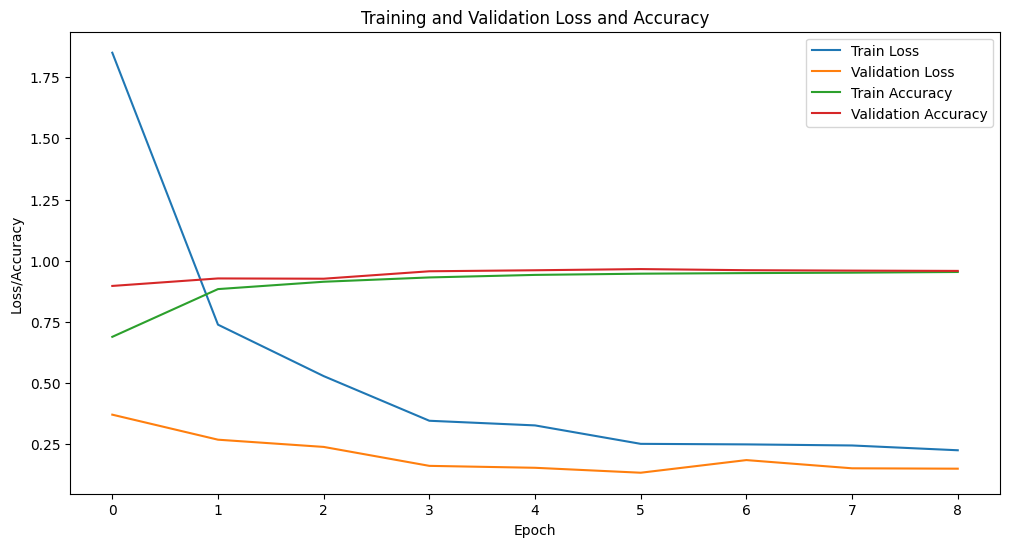

In [10]:

# Print classification report
y_pred_probs = model.predict(X_test_seq)
y_pred_classes = y_pred_probs.argmax(axis=1)
y_true_classes = y_test_seq_labels
print(classification_report(y_true_classes, y_pred_classes))

# confusion matrics
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(cm)

#plot the validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')   
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()



In [11]:
# Calculate FPR and FNR
y_pred_probs = model.predict(X_test_seq)
y_pred_classes = y_pred_probs.argmax(axis=1)
y_true_classes = y_test_seq_labels
cm = confusion_matrix(y_true_classes, y_pred_classes)

# For multi-class, calculate FNR and FPR per class
fnr = []
fpr = []
for i in range(cm.shape[0]):
	fn = cm[i, :].sum() - cm[i, i]
	tp = cm[i, i]
	fp = cm[:, i].sum() - cm[i, i]
	tn = cm.sum() - (tp + fn + fp)
	fnr.append(fn / (fn + tp) if (fn + tp) > 0 else 0)
	fpr.append(fp / (fp + tn) if (fp + tn) > 0 else 0)

print("False Negative Rate (FNR) per class:", fnr)
print("False Positive Rate (FPR) per class:", fpr)

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step
False Negative Rate (FNR) per class: [np.float64(0.0), np.float64(0.009004502251125562), np.float64(0.0335), np.float64(0.05576394098524631), np.float64(0.04784688995215311), np.float64(0.038272407527795836), np.float64(0.061530765382691345), np.float64(0.00450112528132033), np.float64(0.00900225056264066)]
False Positive Rate (FPR) per class: [np.float64(0.0014371741118620312), np.float64(0.006105093120486507), np.float64(0.005784534980401473), np.float64(0.0038127590835124897), np.float64(0.005353428581170935), np.float64(0.005851271321678074), np.float64(0.0028743823641201064), np.float64(0.003064460571795085), np.float64(0.004988656744782697)]


In [12]:
import pandas as pd

# Use type_encoder.classes_ to match the order and number of classes
results_df = pd.DataFrame({
    "Class": type_encoder.classes_,
    "FNR": fnr,
    "FPR": fpr
})

print(results_df.to_string(index=False))


    Class      FNR      FPR
 backdoor 0.000000 0.001437
     ddos 0.009005 0.006105
      dos 0.033500 0.005785
injection 0.055764 0.003813
     mitm 0.047847 0.005353
   normal 0.038272 0.005851
 password 0.061531 0.002874
 scanning 0.004501 0.003064
      xss 0.009002 0.004989
